### 0. About the project.

The aim of the project is to train a diffusion generative model for generating synthetic single-cell data for some rare cell types.
The data used is from [Tabula Sapiens dataset](https://tabula-sapiens.sf.czbiohub.org/).

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns 
import matplotlib.patches as mpatches
import umap
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import trange
import pandas as pd

In [3]:
import warnings
warnings.filterwarnings('ignore')

### 1. Load the single-cell RNA-seq data

In [15]:
cell = sc.read_h5ad("/Users/lijialin/gene46100/final_project/Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad")
cell

AnnData object with n_obs × n_vars = 5007 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

All the cell types:

In [6]:
list(cell.obs['cell_ontology_class'].unique())

['macrophage',
 'monocyte',
 'endothelial cell of hepatic sinusoid',
 'liver dendritic cell',
 'nk cell',
 'fibroblast',
 'hepatocyte',
 'intrahepatic cholangiocyte',
 't cell',
 'neutrophil',
 'plasma cell',
 'erythrocyte',
 'endothelial cell']

#### 1.1 UMAP of all the cells

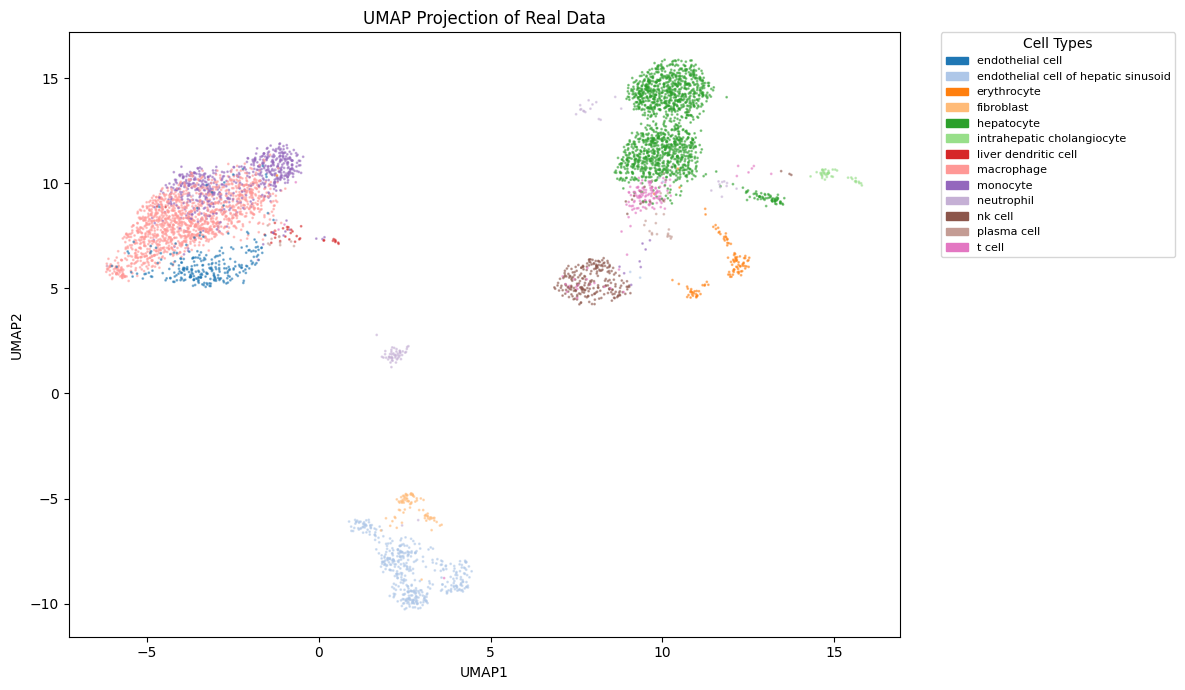

In [31]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# import seaborn as sns 
# import matplotlib.patches as mpatches

# Convert real data to DataFrame
real_data_df = pd.DataFrame(cell.X.toarray())
real_labels = list(cell.obs['cell_ontology_class'].values)

# Encode the labels
label_encoder = LabelEncoder()
label_codes = label_encoder.fit_transform(real_labels)
label_names = label_encoder.classes_

# Run UMAP
import umap
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.6, metric='cosine')
X_umap = umap_model.fit_transform(real_data_df)

# Plot
plt.figure(figsize=(12, 7))


# Assign a unique color to each label
num_labels = len(label_names)
palette = sns.color_palette("tab20", num_labels)  # or use "hls", "Set3", etc.
label_to_color = {label: palette[i] for i, label in enumerate(label_names)}
colors = [label_to_color[label] for label in real_labels]

plt.scatter(X_umap[:, 0], X_umap[:, 1], s=1, alpha=0.5, c=colors)

# Create manual legend with exact label-color mapping
handles = [mpatches.Patch(color=label_to_color[label], label=label) for label in label_names]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Cell Types', fontsize=8)


plt.title('UMAP Projection of Real Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()


### 2. Train a simple diffusion model for one cell type

#### 2.1 Load the hepatocyte data

In [6]:
cell_type_i = cell[cell.obs['cell_ontology_class'] == 'hepatocyte']
cell_type_i

View of AnnData object with n_obs × n_vars = 1558 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'cell_ontology_class_colors', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

  0%|                                           | 1/500 [00:06<57:45,  6.94s/it]

Step 0 | Train Loss: 1.0525 | Val Loss: 1.0089


  5%|██▏                                       | 26/500 [02:20<43:15,  5.48s/it]

Step 25 | Train Loss: 1.0142 | Val Loss: 1.0175


 10%|████▎                                     | 51/500 [04:33<40:57,  5.47s/it]

Step 50 | Train Loss: 1.0169 | Val Loss: 1.0248


 15%|██████▍                                   | 76/500 [06:46<38:44,  5.48s/it]

Step 75 | Train Loss: 1.0152 | Val Loss: 1.0167


 20%|████████▎                                | 101/500 [08:59<36:24,  5.47s/it]

Step 100 | Train Loss: 1.0143 | Val Loss: 1.0108


 25%|██████████▎                              | 126/500 [11:12<34:06,  5.47s/it]

Step 125 | Train Loss: 1.0098 | Val Loss: 1.0082


 30%|████████████▍                            | 151/500 [13:25<31:50,  5.47s/it]

Step 150 | Train Loss: 1.0064 | Val Loss: 1.0054


 35%|██████████████▍                          | 176/500 [15:38<29:30,  5.47s/it]

Step 175 | Train Loss: 1.0041 | Val Loss: 1.0045


 40%|████████████████▍                        | 201/500 [17:51<27:15,  5.47s/it]

Step 200 | Train Loss: 1.0033 | Val Loss: 1.0035


 45%|██████████████████▌                      | 226/500 [20:04<24:58,  5.47s/it]

Step 225 | Train Loss: 1.0025 | Val Loss: 1.0025


 50%|████████████████████▌                    | 251/500 [22:17<22:40,  5.46s/it]

Step 250 | Train Loss: 1.0018 | Val Loss: 1.0024


 55%|██████████████████████▋                  | 276/500 [24:30<20:24,  5.47s/it]

Step 275 | Train Loss: 1.0014 | Val Loss: 1.0022


 60%|████████████████████████▋                | 301/500 [26:48<20:02,  6.04s/it]

Step 300 | Train Loss: 1.0011 | Val Loss: 1.0013


 65%|██████████████████████████▋              | 326/500 [29:20<18:16,  6.30s/it]

Step 325 | Train Loss: 1.0013 | Val Loss: 1.0013


 70%|████████████████████████████▊            | 351/500 [31:53<15:41,  6.32s/it]

Step 350 | Train Loss: 1.0010 | Val Loss: 1.0010


 75%|██████████████████████████████▊          | 376/500 [34:20<11:22,  5.50s/it]

Step 375 | Train Loss: 1.0011 | Val Loss: 1.0016


 80%|████████████████████████████████▉        | 401/500 [36:33<09:00,  5.46s/it]

Step 400 | Train Loss: 1.0011 | Val Loss: 0.9998


 85%|██████████████████████████████████▉      | 426/500 [38:45<06:43,  5.46s/it]

Step 425 | Train Loss: 1.0008 | Val Loss: 1.0004


 90%|████████████████████████████████████▉    | 451/500 [40:58<04:27,  5.45s/it]

Step 450 | Train Loss: 1.0007 | Val Loss: 1.0009


 95%|███████████████████████████████████████  | 476/500 [43:11<02:10,  5.45s/it]

Step 475 | Train Loss: 1.0004 | Val Loss: 1.0014


100%|█████████████████████████████████████████| 500/500 [45:17<00:00,  5.44s/it]


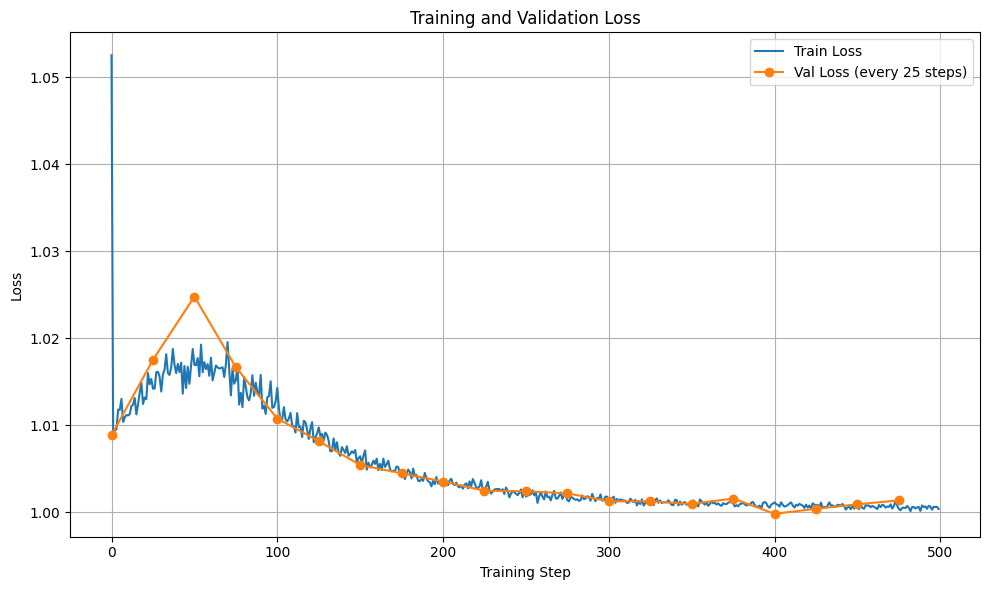

In [10]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange

# 1. Prepare real data
real_data_full = torch.tensor(cell_type_i.X.toarray(), dtype=torch.float32)

# 2. Split into training and validation sets
train_data, val_data = train_test_split(real_data_full, test_size=0.2, random_state=42)

# 3. Define time-dependent beta schedule
n_steps = 1000
betas = torch.linspace(1e-4, 0.02, n_steps)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# 4. Define the model
class DenoiseMLP(nn.Module):
    def __init__(self, n_genes, t_embed_dim=32):
        super().__init__()
        self.time_embed = nn.Embedding(n_steps, t_embed_dim)
        self.net = nn.Sequential(
            nn.Linear(n_genes + t_embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, n_genes)
        )
    def forward(self, x, t):
        t_emb = self.time_embed(t)
        x_cat = torch.cat([x, t_emb], dim=1)
        return self.net(x_cat)

n_genes = real_data_full.shape[1]
model = DenoiseMLP(n_genes)

# 5. Forward diffusion: add noise based on time step t
def add_noise(x0, t):
    """
    Adds noise to x0 according to alpha_bar[t].
    """
    batch_size = x0.size(0)
    alpha_bar_t = alpha_bars[t].unsqueeze(1)  # shape [B, 1]
    noise = torch.randn_like(x0)
    noisy_x = torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * noise
    return noisy_x, noise


# 6. Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Containers to store losses
train_losses = []
val_losses = []

# 7. Training loop with validation
for step in trange(500):  # increase number of steps
    model.train()
    t_train = torch.randint(0, n_steps, (train_data.size(0),))
    noisy_train, noise_train = add_noise(train_data, t_train)
    pred_noise_train = model(noisy_train, t_train)
    loss_train = ((noise_train - pred_noise_train) ** 2).mean()

    loss_train.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Store training loss
    train_losses.append(loss_train.item())

    # Validation
    if step % 25 == 0:
        model.eval()
        with torch.no_grad():
            t_val = torch.randint(0, n_steps, (val_data.size(0),))
            noisy_val, noise_val = add_noise(val_data, t_val)
            pred_noise_val = model(noisy_val, t_val)
            loss_val = ((noise_val - pred_noise_val) ** 2).mean()
            val_losses.append((step, loss_val.item()))

        print(f"Step {step} | Train Loss: {loss_train.item():.4f} | Val Loss: {loss_val.item():.4f}")

# 8. Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
if val_losses:
    val_steps, val_vals = zip(*val_losses)
    plt.plot(val_steps, val_vals, 'o-', label='Val Loss (every 25 steps)')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model_path = "/Users/lijialin/gene46100/final_project/denoise_mlp_diffusion.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


### 3. Generate synthetic hepatocyte data

#### 3.1 Generate using diffusion model

In [12]:
model_path = "/Users/lijialin/gene46100/final_project/denoise_mlp_diffusion.pth"


# 3. Define time-dependent beta schedule
n_steps = 1000
betas = torch.linspace(1e-4, 0.02, n_steps)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# 4. Define the model
class DenoiseMLP(nn.Module):
    def __init__(self, n_genes, t_embed_dim=32):
        super().__init__()
        self.time_embed = nn.Embedding(n_steps, t_embed_dim)
        self.net = nn.Sequential(
            nn.Linear(n_genes + t_embed_dim, 512),
            nn.ReLU(),
            nn.Linear(512, n_genes)
        )
    def forward(self, x, t):
        t_emb = self.time_embed(t)
        x_cat = torch.cat([x, t_emb], dim=1)
        return self.net(x_cat)

In [14]:
# Define the reverse diffusion process to generate synthetic data
def reverse_diffusion(model, noise_data, n_steps=80, beta=0.02):
    for t in reversed(range(n_steps)):
        # Convert timestep to tensor for the model input
        t_tensor = torch.tensor([t], dtype=torch.long)  # Convert to tensor
        # Add reverse noise process
        noise_pred = model(noise_data, t_tensor)  # Pass timestep as tensor
        noise_data = (noise_data - (beta ** 0.5) * noise_pred) / (1 - beta)**0.5
    return noise_data

# Re-initialize the model (if you haven't already)
n_genes = cell_type_i.X.shape[1]  # Number of genes
model = DenoiseMLP(n_genes)
model.load_state_dict(torch.load(model_path))  # Load the trained model
model.eval()  # Set to evaluation mode

# Generate 200 new synthetic samples
n_synthetic_samples = 200
synthetic_data = []

for _ in range(n_synthetic_samples):
    # Start with random noise
    noise_data = torch.randn(1, n_genes)  # Create random noise
    synthetic_sample = reverse_diffusion(model, noise_data)  # Generate synthetic data using reverse diffusion
    synthetic_data.append(synthetic_sample)

# Convert the list of tensors to a single tensor
synthetic_data = torch.cat(synthetic_data, dim=0)

# # Optionally, save the generated synthetic data to a file
# np.savetxt("synthetic_macrophage_data.csv", synthetic_data.numpy(), delimiter=",")

# print("Generated 1000 synthetic samples and saved to 'synthetic_macrophage_data.csv'.")

synthetic_data = synthetic_data.detach().numpy()

synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df.to_csv('/Users/lijialin/gene46100/final_project/synthetic_macrophage_data.csv')


In [20]:
synthetic_df = pd.read_csv('/Users/lijialin/gene46100/final_project/synthetic_macrophage_data.csv', index_col = 0)
synthetic_df

,0,1,2,3,4,5,6,7,8,9,...,58860,58861,58862,58863,58864,58865,58866,58867,58868,58869
0,2.205396,0.006347,4.946915,-3.528331,5.017487,0.295589,-2.890484,2.008939,-0.262131,-0.490549,...,2.115228,-1.703809,0.776750,1.976435,0.716206,2.719512,2.206254,-4.167647,-0.835566,2.355107
1,-1.850584,-0.215957,0.159306,-1.067826,0.704074,0.893315,-1.755915,0.868482,1.672347,-0.081315,...,0.566488,-1.000270,2.125350,4.657302,0.521463,-2.889981,-3.226455,0.424687,-2.131855,-2.600432
2,0.103852,3.123705,-3.010880,2.541852,0.685014,2.285475,0.332984,3.966201,4.610631,4.581717,...,0.716842,-2.140211,0.243558,-0.286242,0.727193,-4.096992,1.758401,-3.062931,-1.699664,3.291856
3,-1.534649,1.540374,0.297784,-2.497759,6.454445,0.439627,-0.777480,0.051764,-1.216155,3.715610,...,1.118663,2.978426,-3.222101,-0.146420,1.218469,-2.090649,-0.973883,-1.526684,-1.557047,-1.950162
4,0.728175,0.323483,1.676936,1.956922,1.179017,-0.207385,-7.708888,1.604435,4.896671,4.633883,...,-3.071206,0.073341,0.307201,1.792022,2.426494,-0.071853,-1.495551,0.007885,0.280930,0.920156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.811591,1.598118,-0.701471,1.910659,0.753039,-4.863944,-1.048752,4.929493,3.066534,-2.108087,...,-2.855309,1.206363,-1.139786,-0.508393,3.542189,-1.567896,7.494770,-0.294693,2.531098,-0.145339
196,-3.788154,2.174357,-5.509092,-1.608404,3.074268,-0.144386,0.121535,-1.167959,-3.633869,0.240590,...,-3.030178,-3.026378,2.766339,0.768252,-2.648270,-0.621966,1.608125,-0.677482,-0.956512,1.187583
197,0.986530,1.703611,-1.827127,-3.890140,-6.564373,-1.743796,0.445073,-0.082226,0.795082,3.963368,...,-1.643756,1.902357,1.161335,-2.210285,0.025051,-3.823431,-1.697804,0.001021,-3.984081,1.242471
198,-3.944082,0.742723,-2.704560,0.124768,-0.682306,1.048637,-1.419054,-1.038645,-2.344205,-3.776291,...,1.273202,0.555768,-1.064687,-1.186318,0.728092,-6.601905,0.755946,-0.073920,1.637833,-3.238699


In [21]:
synthetic_diff = np.array(synthetic_df)

#### 3.2 Generate using a Gaussian generator
Very simple version, and assume that each gene expression is independent to others.

In [8]:
from sklearn.preprocessing import StandardScaler

# Step 1: Ensure the data is dense
real_data_full = torch.tensor(cell_type_i.X.toarray(), dtype=torch.float32)

# Convert PyTorch tensor to numpy
real_data_dense = real_data_full.detach().cpu().numpy()

# Fit a Gaussian to each feature (assume independence)
feature_means = np.mean(real_data_dense, axis=0)
feature_stds = np.std(real_data_dense, axis=0) + 1e-6  # small epsilon to avoid 0 std

# Sample 200 new cells
synthetic_data = np.random.normal(loc=feature_means, scale=feature_stds, size=(200, real_data_dense.shape[1]))

synthetic_df_nm = pd.DataFrame(synthetic_data)
synthetic_df_nm

,0,1,2,3,4,5,6,7,8,9,...,58860,58861,58862,58863,58864,58865,58866,58867,58868,58869
0,1.755770e-06,-8.815444e-07,-2.078299e-07,-8.322774e-07,-2.631325e-06,1.022481e-06,4.598981e-07,-1.350362e-06,-1.776603e-07,-0.811441,...,0.606858,2.424205,-0.331598,0.129947,1.430535,-0.030610,-0.105733,3.244691,-0.266289,0.904658
1,2.294705e-06,3.143003e-07,-3.446889e-07,-1.823067e-07,5.322700e-07,8.040780e-07,-6.371475e-07,2.004963e-08,3.097985e-06,0.086066,...,1.256226,-0.383440,1.208056,0.444669,4.699903,-0.162356,0.381123,1.567160,-0.261237,2.118912
2,-2.914647e-07,-9.201874e-07,7.596740e-07,-2.035835e-06,-3.566191e-07,-1.062827e-06,2.169666e-07,8.044001e-07,-1.572876e-07,1.125304,...,3.118594,-1.417014,1.179203,0.015598,2.898863,0.837382,0.197464,3.230792,0.562922,-2.055996
3,-7.782282e-08,2.813975e-07,-8.894439e-07,7.465449e-07,8.895649e-07,-1.235892e-06,8.306710e-08,1.731598e-06,-8.754179e-07,-0.404868,...,4.433524,-0.399361,-0.014580,-0.088497,1.683922,2.164565,0.538619,4.419945,0.024406,2.016950
4,-1.356524e-06,1.375293e-06,-8.128394e-07,-1.589207e-06,-4.013786e-07,-7.896820e-07,8.853905e-07,-9.052152e-08,9.402257e-07,-1.121715,...,1.484294,-0.182572,0.468989,-0.160674,1.114417,1.532459,-0.775480,4.839691,0.052641,1.933033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,4.828976e-07,-1.617072e-06,1.511183e-07,7.706641e-07,2.063540e-07,3.921039e-08,2.002673e-07,-2.332549e-07,-9.444607e-07,0.710502,...,5.602297,0.259618,-0.243951,-0.366100,0.773239,1.734257,1.637041,3.415790,-0.415544,3.252157
196,-7.522621e-07,1.682863e-06,-1.385939e-06,-1.356664e-06,1.029380e-06,1.807546e-06,4.384485e-07,-1.535736e-06,4.862420e-07,1.854628,...,4.067509,0.834317,-1.064662,-0.157924,-0.596021,0.786758,1.079469,4.191566,-0.170566,0.066686
197,-3.728532e-07,-6.044887e-07,-2.510121e-07,6.130212e-07,7.393119e-07,-6.543440e-07,-2.061900e-06,1.136701e-06,6.102259e-07,0.919220,...,-2.538609,0.026587,1.255900,-0.641853,3.177992,0.100037,0.200496,2.568259,-0.208258,0.515993
198,1.764377e-06,-2.830839e-07,-7.749614e-07,1.386036e-06,-1.094726e-06,-3.013336e-07,6.510604e-07,1.998365e-07,1.451779e-07,0.357953,...,0.771040,0.875125,-0.414818,0.227160,0.731093,1.288242,3.000701,2.509276,-0.642951,2.621636


#### 4. UMAP of the synthetic data and the real data

#### 4.1 diffusion model

In [16]:
real = pd.DataFrame(cell.X.toarray())
real_label = list(cell.obs['cell_ontology_class'].values)


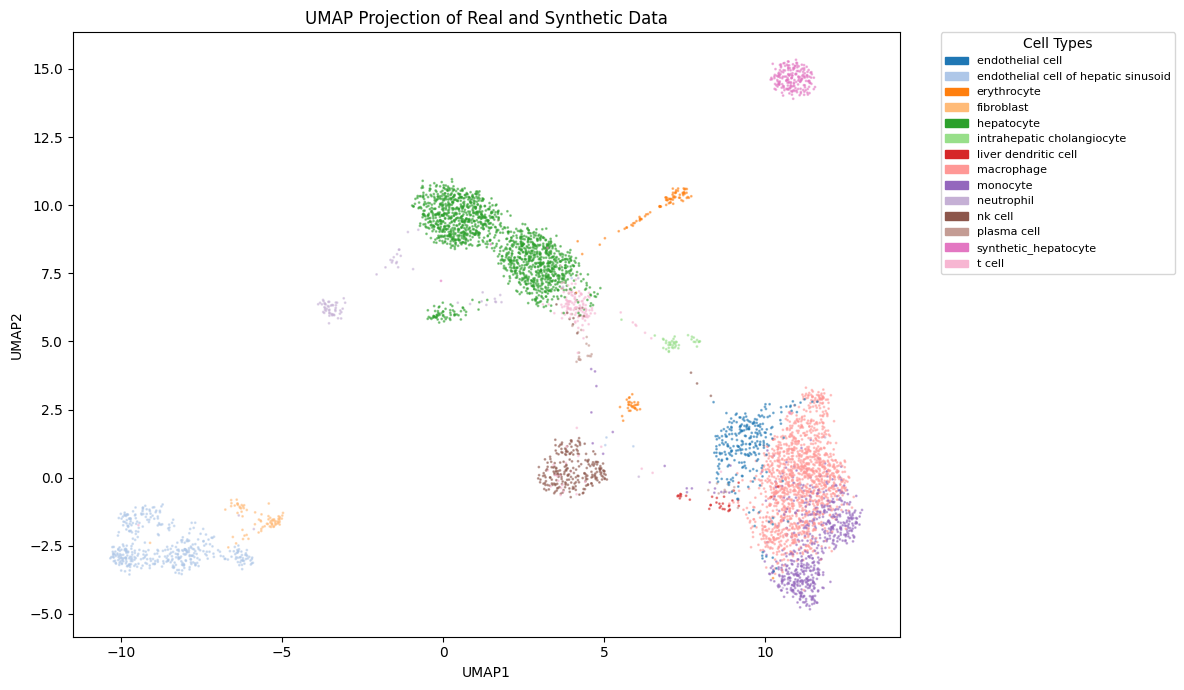

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder

# Combine real and synthetic data
real_data_df = pd.DataFrame(cell.X.toarray())  # Convert the real data to DataFrame
real_labels = list(cell.obs['cell_ontology_class'].values)

# Create synthetic data DataFrame (assuming synthetic_data is generated)
synthetic_data_df = synthetic_df  # Convert synthetic data to DataFrame
synthetic_labels = ['synthetic_hepatocyte'] * synthetic_data_df.shape[0]  # Synthetic label

# Combine the real and synthetic data
combined_data = pd.concat([real_data_df, synthetic_data_df], ignore_index=True)
combined_labels = real_labels + synthetic_labels

# Encode the labels
label_encoder = LabelEncoder()
label_codes = label_encoder.fit_transform(combined_labels)
label_names = label_encoder.classes_

# Run UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.6, metric='cosine')
X_umap = umap_model.fit_transform(combined_data)

# Plot
plt.figure(figsize=(12, 7))


# Assign a unique color to each label
num_labels = len(label_names)
palette = sns.color_palette("tab20", num_labels)  # or use "hls", "Set3", etc.
label_to_color = {label: palette[i] for i, label in enumerate(label_names)}
colors = [label_to_color[label] for label in combined_labels]

plt.scatter(X_umap[:, 0], X_umap[:, 1], s=1, alpha=0.5, c=colors)

# Create manual legend with exact label-color mapping
handles = [mpatches.Patch(color=label_to_color[label], label=label) for label in label_names]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Cell Types', fontsize=8)


plt.title('UMAP Projection of Real and Synthetic Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()



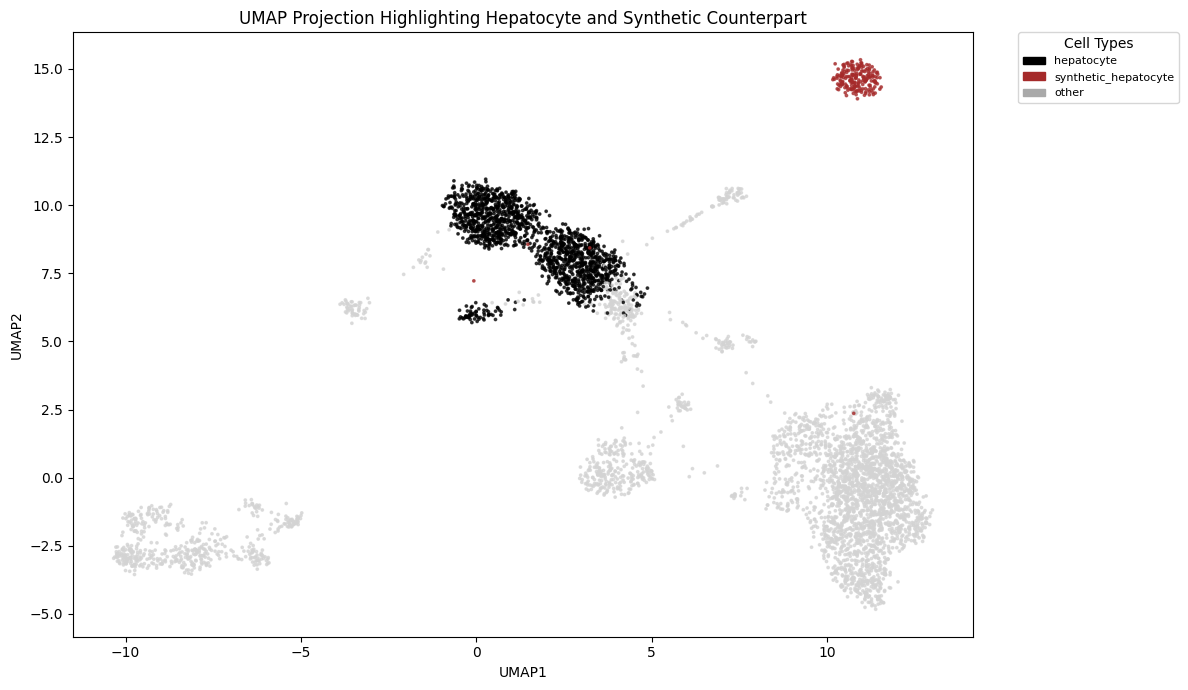

In [38]:
# Color map logic
highlight_colors = {
    'hepatocyte': 'black',
    'synthetic_hepatocyte': 'brown'
}
colors = [highlight_colors[label] if label in highlight_colors else 'lightgrey' for label in combined_labels]

# Plot
plt.figure(figsize=(12, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=3, alpha=0.7, c=colors)

# Create custom legend
handles = [
    mpatches.Patch(color='black', label='hepatocyte'),
    mpatches.Patch(color='brown', label='synthetic_hepatocyte'),
    mpatches.Patch(color='darkgrey', label='other')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Cell Types', fontsize=8)

plt.title('UMAP Projection Highlighting Hepatocyte and Synthetic Counterpart')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

#### 4.2 Simple Gaussian generator

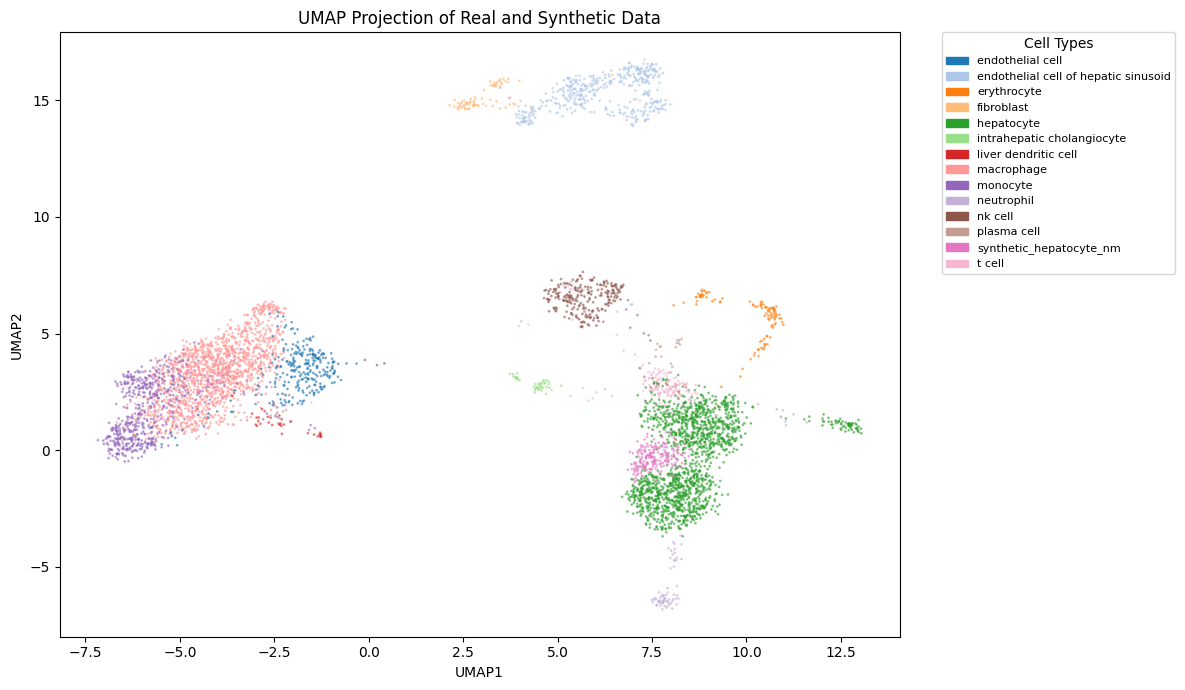

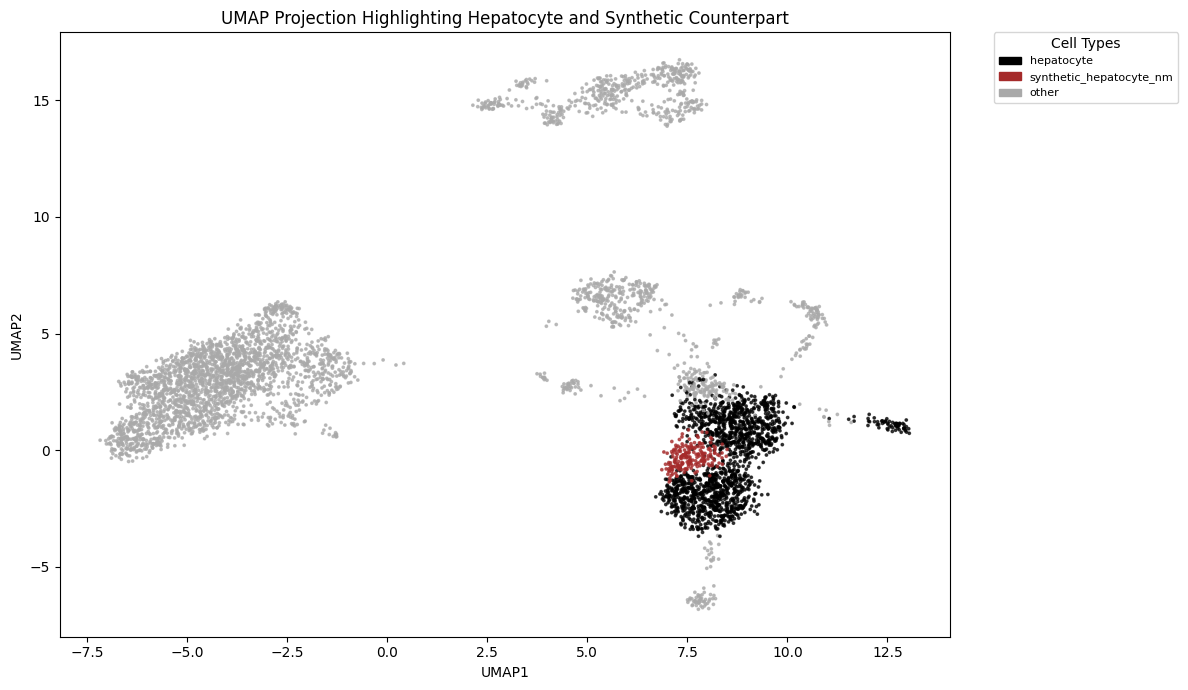

In [11]:
real = pd.DataFrame(cell.X.toarray())
real_label = list(cell.obs['cell_ontology_class'].values)

from sklearn.preprocessing import LabelEncoder

# Combine real and synthetic data
real_data_df = pd.DataFrame(cell.X.toarray())  # Convert the real data to DataFrame
real_labels = list(cell.obs['cell_ontology_class'].values)


# Create synthetic data DataFrame (assuming synthetic_data is generated)
synthetic_data_df = synthetic_df_nm  # Convert synthetic data to DataFrame
synthetic_labels = ['synthetic_hepatocyte_nm'] * synthetic_data_df.shape[0]  # Synthetic label

# Combine the real and synthetic data
combined_data = pd.concat([real_data_df, synthetic_data_df], ignore_index=True)
combined_labels = real_labels + synthetic_labels

# Encode the labels
label_encoder = LabelEncoder()
label_codes = label_encoder.fit_transform(combined_labels)
label_names = label_encoder.classes_

# Run UMAP
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.6, metric='cosine')
X_umap = umap_model.fit_transform(combined_data)

# Plot
plt.figure(figsize=(12, 7))


# Assign a unique color to each label
num_labels = len(label_names)
palette = sns.color_palette("tab20", num_labels)  # or use "hls", "Set3", etc.
label_to_color = {label: palette[i] for i, label in enumerate(label_names)}
colors = [label_to_color[label] for label in combined_labels]

plt.scatter(X_umap[:, 0], X_umap[:, 1], s=1, alpha=0.5, c=colors)

# Create manual legend with exact label-color mapping
handles = [mpatches.Patch(color=label_to_color[label], label=label) for label in label_names]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Cell Types', fontsize=8)


plt.title('UMAP Projection of Real and Synthetic Data')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()



# Color map logic
highlight_colors = {
    'hepatocyte': 'black',
    'synthetic_hepatocyte_nm': 'brown'
}
colors = [highlight_colors[label] if label in highlight_colors else 'darkgrey' for label in combined_labels]

# Plot
plt.figure(figsize=(12, 7))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=3, alpha=0.7, c=colors)

# Create custom legend
handles = [
    mpatches.Patch(color='black', label='hepatocyte'),
    mpatches.Patch(color='brown', label='synthetic_hepatocyte_nm'),
    mpatches.Patch(color='darkgrey', label='other')
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Cell Types', fontsize=8)

plt.title('UMAP Projection Highlighting Hepatocyte and Synthetic Counterpart')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

### 5. Jensen-Shannon (JS) divergence as a metric to evaluate the performance

The JS divergence between two continuous probability distributions \( P(x) \) and \( Q(x) \) is:

$$
\mathrm{JS}(P \parallel Q) = \frac{1}{2} D_{\mathrm{KL}}(P \parallel M) + \frac{1}{2} D_{\mathrm{KL}}(Q \parallel M), \quad \text{where } M(x) = \frac{1}{2}(P(x) + Q(x))
$$

and

$$
D_{\mathrm{KL}}(P \parallel Q) = \int P(x) \log \frac{P(x)}{Q(x)} \, dx
$$

**Where:**

- \( P(x) \) and \( Q(x) \) are continuous probability density functions  
- \( M(x) \) is the average distribution
- D_{\mathrm{KL}} is the Kullback–Leibler divergence


JS divergence is a symmetric and smoothed version of KL divergence, always bounded between 0 (identical distributions) and 1 (maximally different, if using log base 2). For generative models, it quantifies how well the synthetic data approximates the real data distribution.

In practice, it is often computed feature-wise, then averaged across all features (e.g., genes in scRNA-seq data). A lower JS divergence indicates better alignment between real and synthetic data distributions, suggesting that the generator is more effective.

In [13]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from sklearn.preprocessing import normalize

def compute_js_divergence(real, synthetic, num_bins=50):
    """
    Computes average JS divergence across all features assuming feature independence.
    
    Parameters:
        real (np.ndarray): Real data matrix [obs x features].
        synthetic (np.ndarray): Synthetic data matrix [obs x features].
        num_bins (int): Number of bins to use for histogram estimation.

    Returns:
        float: Mean JS divergence across features.
        np.ndarray: JS divergence per feature.
    """
    n_features = real.shape[1]
    js_scores = []

    for i in range(n_features):
        real_feat = real[:, i]
        synth_feat = synthetic[:, i]

        # Compute histograms over the same bin edges
        min_val = min(real_feat.min(), synth_feat.min())
        max_val = max(real_feat.max(), synth_feat.max())
        bins = np.linspace(min_val, max_val, num_bins + 1)

        real_hist, _ = np.histogram(real_feat, bins=bins, density=True)
        synth_hist, _ = np.histogram(synth_feat, bins=bins, density=True)

        # Add a small constant to avoid zeros, then normalize
        real_hist += 1e-8
        synth_hist += 1e-8
        real_hist /= real_hist.sum()
        synth_hist /= synth_hist.sum()

        # JS divergence via scipy (returns sqrt(JS), so square it)
        js = jensenshannon(real_hist, synth_hist) ** 2
        js_scores.append(js)

    return np.mean(js_scores), np.array(js_scores)


In [23]:
# Example usage:
# real_data, synthetic_data: shape [obs x features], both should be np.ndarray
mean_js, _ = compute_js_divergence(real_data_full, synthetic_diff)
print(f"Mean JS divergence across features with diffusion model: {mean_js:.4f}")

mean_js, _ = compute_js_divergence(real_data_full, synthetic_data)
print(f"Mean JS divergence across features with Gaussian generator: {mean_js:.4f}")

Mean JS divergence across features with diffusion model: 0.5726
Mean JS divergence across features with Gaussian generator: 0.5201


Gaussian generator has smaller JS divergence, means it performs better.

#### 5.1 Discussion

The possible reasons that diffusion models is worse than a simple gaussian generator:
* Insufficient training – Diffusion models need long training to learn the full data distribution. Undertraining leads to poor sample quality.

* Feature independence – If your data has mostly independent features, a simple Gaussian generator may already be near-optimal, making the diffusion model's complexity unnecessary.

* Sampling issues – Diffusion sampling is sensitive. Too few steps or poorly tuned parameters can degrade output quality, especially with MLPs that aren’t robust to this.



In general, diffusion models should outperform Gaussian generators because they model complex data distributions through a gradual denoising process, allowing them to capture intricate, multi-modal structures that Gaussian models—even with correlated features—struggle to represent. Unlike Gaussian generators, which assume a fixed global distribution shape, diffusion models learn a flexible generative process that better matches real-world data's heterogeneity and non-linearity. This makes them particularly effective for high-dimensional, structured data like images or single-cell transcriptomics.